# Team 3 Final Project - Modeling

We will be using a variety of Machine Learning Models in an unsupervised manner to produce a Collaborative Filtering based Recommender System.

K Nearest Neigbors will produce the actual recommendations based on cosine similarity between anime titles. Recommendations will be made based on user's last watched anime, this will be the query for KNN. Titles already watched (completed) by the user will be excluded from the dataset for KNN (don't want to recommend already watched titles). The K (default 10) nearest neighbors to the last watched title will be the recommendations.

BERT Model (Bi-Directional Encoder Representations from Transformers) - Default Pre-Trained BERT model will be used on the synopsis table to generate a vector embedding or semantic representation that can be used by KNN to produce more distinct recommendations. **Note: This will significantly increase the complexity of the project and will only be used if there is enough time to implement**

K-Means Clustering - There are currently 36 unique genres that may be too similar and titles can be attached to many genres. We want to simply the genres by generating clusters that will serve to reduce the dimenionality from 36 genres to k - clusters.

In [1]:
!pip install pyathena

     |████████████████████████████████| 40 kB 4.3 MB/s eta 0:00:011
     |████████████████████████████████| 132 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 8.6 MB 13.7 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 19.8 MB/s eta 0:00:01


In [ ]:
# This is for MAR@K metrics
!pip install recmetrics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

## Import training set

In [3]:
training = pd.read_csv('training.csv')

In [4]:
training

,user_id,anime_id,user_rating,watching_status,watched_episodes,mal_id,aggregated_score,episodes,rating,ranked,...,Yaoi,Yuri,Movie,Music.2,Music.3,ONA,OVA,Other,Special,TV
0,336145,2251,10,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,228773,2251,9,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,61090,2251,10,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,26848,2251,9,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,195185,2251,8,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999991,300428,13503,0,4,0,13503,6.509999,11.0,3,13708.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
999992,30459,34369,0,4,0,34369,6.509999,5.0,3,14403.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0
999993,275530,7779,0,4,0,7779,6.210000,52.0,2,7295.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
999994,272555,40406,0,4,0,40406,6.509999,16.0,1,15754.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
training.columns

Index(['user_id', 'anime_id', 'user_rating', 'watching_status',
       'watched_episodes', 'mal_id', 'aggregated_score', 'episodes', 'rating',
       'ranked', 'popularity', 'members', 'score_10', 'score_9', 'score_8',
       'score_7', 'score_6', 'score_5', 'score_4', 'score_3', 'score_2',
       'score_1', 'days_since_aired', 'Action', 'Adventure', 'Cars', 'Comedy',
       'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem',
       'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Music.1', 'Mystery',
       'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School',
       'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri', 'Movie', 'Music.2',
       'Music.3', 'ONA', 'OVA', 'Other', 'Special', 'TV'],
      dtype='object')

## Import anime subset

Used for KNN of titles

In [6]:
anime_subset = pd.read_csv('anime_subset.csv')

In [7]:
anime_subset

,mal_id,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,...,Yaoi,Yuri,Movie,Music.2,Music.3,ONA,OVA,Other,Special,TV
0,1,8.780000,26.0,5,28.0,39,1251960,229170.0,182126.0,131625.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,8.390000,1.0,5,159.0,518,273145,30043.0,49201.0,49505.0,...,0,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,8.240000,26.0,3,266.0,201,558913,50229.0,75651.0,86142.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,7,7.270000,26.0,3,2481.0,1467,94683,2182.0,4806.0,10128.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,8,6.980000,52.0,2,3710.0,4369,13224,312.0,529.0,1242.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,6.509999,2.0,6,7896.0,13116,354,39.0,71.0,92.0,...,0,0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0
17558,48483,6.509999,2.0,6,7896.0,17562,7010,39.0,71.0,92.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
17559,48488,6.509999,2.0,5,7896.0,17558,11309,1.0,71.0,92.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
17560,48491,6.509999,2.0,3,7896.0,17565,1386,39.0,71.0,92.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
anime_subset.set_index(['mal_id'], inplace=True)

### Standardization and Min-max scaling variables

In [9]:
anime_subset.columns

Index(['score', 'episodes', 'rating', 'ranked', 'popularity', 'members',
       'score_10', 'score_9', 'score_8', 'score_7', 'score_6', 'score_5',
       'score_4', 'score_3', 'score_2', 'score_1', 'days_since_aired',
       'Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music',
       'Music.1', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance',
       'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai',
       'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports',
       'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi',
       'Yuri', 'Movie', 'Music.2', 'Music.3', 'ONA', 'OVA', 'Other', 'Special',
       'TV'],
      dtype='object')

In [10]:
# Drop Music.2 and Music.3
anime_subset = anime_subset.drop(columns=['Music.2', 'Music.3'])

In [11]:
# Standard Scale the aggregated user score
anime_subset['score'] = StandardScaler().fit_transform(anime_subset[['score']])

In [12]:
# Min-max scaling
mm_scaling_cols = ['episodes', 'rating', 'ranked', 'popularity', 'members',
       'score_10', 'score_9', 'score_8', 'score_7', 'score_6', 'score_5',
       'score_4', 'score_3', 'score_2', 'score_1', 'days_since_aired']
anime_subset[mm_scaling_cols] = MinMaxScaler().fit_transform(anime_subset[mm_scaling_cols])

In [13]:
# Post scaling
anime_subset

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,Unknown,Vampire,Yaoi,Yuri,Movie,ONA,OVA,Other,Special,TV
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## Clustering using Kmeans

We want to cluster the titles into distinct groups to prevent same similarity measures when using KNN. This will also reduce dimensionality of the dataset by replacing the genre columns with these clusters

In [14]:
genres_list = ['Dementia', 'Shounen Ai', 'Adventure', 'Music', 'Martial Arts', 'Kids',
               'Sports', 'Action', 'Cars', 'Hentai', 'Slice of Life', 'Vampire', 'Seinen',
               'Thriller', 'Romance', 'Samurai', 'Historical', 'Drama', 'Unknown', 'Psychological', 'Comedy', 
               'Mystery', 'Josei', 'Military', 'Ecchi', 'Magic', 'Supernatural', 'Yaoi', 'Shounen', 'Sci-Fi', 
               'Super Power', 'Demons', 'Parody', 'Horror', 'Police', 'Fantasy', 'Game', 'Shoujo', 'Harem',
               'School', 'Space', 'Mecha', 'Shoujo Ai', 'Yuri']

In [15]:
anime_subset

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,Unknown,Vampire,Yaoi,Yuri,Movie,ONA,OVA,Other,Special,TV
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'Elbow curve')

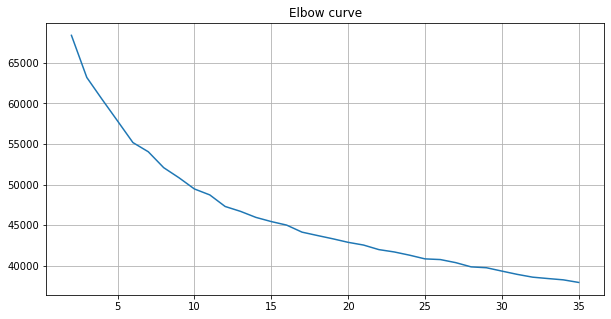

In [16]:
distorsions = []
for k in range(2, 36):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(anime_subset)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 36), distorsions)
plt.grid(True)
plt.title('Elbow curve')

### K-Means Results

Based on inertia, 10 clusters will best represent the anime titles and the cluster assignments will replace the genres

In [17]:
km_10 = KMeans(10)
g_clusters = km_10.fit(anime_subset)

In [18]:
anime_subset['cluster'] = g_clusters.labels_

In [19]:
anime_subset

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,Vampire,Yaoi,Yuri,Movie,ONA,OVA,Other,Special,TV,cluster
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,5
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,7
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,5
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,5
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,9
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [20]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(anime_subset[['cluster']])
cluster_10 = pd.DataFrame(enc.transform(anime_subset[['cluster']]), columns=['g_cluster_' + str(i) for i in range(1, 11)])

In [21]:
cluster_10 = cluster_10.astype('int')

In [22]:
# need the index (mal_id) from the genres dataframe
cluster_10.index = anime_subset.index

In [23]:
cluster_10

,g_cluster_1,g_cluster_2,g_cluster_3,g_cluster_4,g_cluster_5,g_cluster_6,g_cluster_7,g_cluster_8,g_cluster_9,g_cluster_10
mal_id,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
48481,0,0,0,0,0,0,0,0,0,1
48483,1,0,0,0,0,0,0,0,0,0
48488,1,0,0,0,0,0,0,0,0,0


## Replace the genres columns with clusters

Dimensionality was reduced from 74 to 39 columns

In [24]:
# drop the original genres columns
training_w_clusters = training.drop(columns=genres_list)
training_w_clusters = pd.merge(training_w_clusters, cluster_10, left_on='mal_id', right_index=True)
training_w_clusters.drop(columns=['mal_id'], inplace=True)

In [25]:
training_w_clusters.sort_values(['user_id']).set_index(['user_id', 'anime_id'])

user_rating  watching_status  watched_episodes  \
user_id anime_id                                                   
0       269                 9                3                64   
1       33486               8                2                25   
3       71                  7                2                24   
        10379               8                2                13   
        9863                9                2                77   
...                       ...              ...               ...   
353398  31630               6                2                24   
        17247               8                3                 3   
        5734                7                2                12   
        36144               0                1                 0   
353401  34662               0                6                 0   

                  aggregated_score  episodes  rating  ranked  popularity  \
user_id anime_id                                                           
0       269                   7.80     366.0       3   818.0          33   
1       33486                 8.33      25.0       3   203.0          13   
3       71                    7.65      24.0       5  1146.0         322   
        10379                 8.60      13.0       3    67.0         738   
        9863                  8.25      77.0       3   262.0         804   
...                            ...       ...     ...     ...         ...   
353398  31630                 6.45      24.0       3  6182.0        1322   
        17247                 7.15      12.0       4  3003.0         553   
        5734                  6.78      12.0       3  4520.0        1981   
        36144                 7.17      24.0       5  2907.0        2034   
353401  34662                 7.16      25.0       5  2937.0         402   

                  members  score_10  ...  g_cluster_1  g_cluster_2  \
user_id anime_id                     ...                             
0       269       1286382  116063.0  ...            0            0   
1       33486     1611771  188165.0  ...            0            0   
3       71         411230   17675.0  ...            0            0   
        10379      200904   23877.0  ...            0            0   
        9863       185346   11534.0  ...            0            0   
...                   ...       ...  ...          ...          ...   
353398  31630      107475    1791.0  ...            1            0   
        17247      264089    7926.0  ...            0            0   
        5734        61027    1438.0  ...            1            0   
        36144       59132    1023.0  ...            0            0   
353401  34662      339526   12121.0  ...            0            0   

                  g_cluster_3  g_cluster_4  g_cluster_5  g_cluster_6  \
user_id anime_id                                                       
0       269                 0            0            0            1   
1       33486               0            0            0            1   
3       71                  0            0            0            1   
        10379               0            0            0            1   
        9863                0            0            0            1   
...                       ...          ...          ...          ...   
353398  31630               0            0            0            0   
        17247               0            0            0            1   
        5734                0            0            0            0   
        36144               0            0            0            1   
353401  34662               0            0            0            1   

                  g_cluster_7  g_cluster_8  g_cluster_9  g_cluster_10  
user_id anime_id                                                       
0       269                 0            0            0             0  
1       33486               0            0            0             0  
3       

In [26]:
# Do the same for anime_subset
anime_clusters = anime_subset.drop(columns=genres_list)
anime_clusters = pd.merge(anime_clusters, cluster_10, left_on='mal_id', right_index=True)

In [27]:
anime_clusters

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,g_cluster_1,g_cluster_2,g_cluster_3,g_cluster_4,g_cluster_5,g_cluster_6,g_cluster_7,g_cluster_8,g_cluster_9,g_cluster_10
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0,0,1,0,0,0,0
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,0,0,0,0,1,0,0
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0,0,1,0,0,0,0
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0,0,1,0,0,0,0
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0,0,0,0,0,0,1
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,1,0,0,0,0,0,0,0,0,0
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,1,0,0,0,0,0,0,0,0,0


# K Nearest Neighbors Model

Since we're using KNN in an unsupervised manner (no labels, no classifications) we will use NearestNeigbors vs KNeighborsClassifier

**Notes**
KNN will use the anime_subset with cluster assignments

In [28]:
knn = NearestNeighbors(metric="cosine")
knn.fit(anime_clusters)

NearestNeighbors(metric='cosine')

## Test Query

The test query will include itself as a recommendation, this will be excluded for final inferences

In [29]:
# Load the original anime table for title information
anime = pd.read_csv('anime.csv')

### Query Title

In [30]:
anime[anime['MAL_ID'] == anime_clusters.iloc[1, :].name]

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [31]:
distances, titles = knn.kneighbors(anime_clusters.iloc[1, :].values.reshape(1, -1), n_neighbors=10)

In [32]:
# Sort by distances, smallest to largest
distances

array([[1.11022302e-16, 1.24072816e-04, 1.58546444e-04, 1.83290827e-04,
        4.30894423e-04, 4.49835570e-04, 4.83093421e-04, 4.86150256e-04,
        5.11266226e-04, 5.21165514e-04]])

In [33]:
# Recommendation rows ordered by distances
list(titles[0])

[1, 2215, 2813, 6893, 6229, 8139, 2373, 14023, 409, 13991]

In [34]:
# Convert rows to anime_ids
anime_clusters.iloc[list(titles[0]), :].index.tolist()

[5, 2418, 5205, 9260, 7472, 25537, 4282, 37055, 437, 36999]

### Recommended Titles based on Query

In [35]:
anime[anime['MAL_ID'].isin(anime_clusters.iloc[list(titles[0]), :].index.tolist())][['MAL_ID', 'Name', 'Genres']]

,MAL_ID,Name,Genres
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space"
409,437,Perfect Blue,"Dementia, Drama, Horror, Psychological"
2215,2418,Stranger: Mukou Hadan,"Action, Adventure, Historical, Samurai"
3578,4282,Kara no Kyoukai 5: Mujun Rasen,"Action, Mystery, Supernatural, Drama, Romance,..."
4018,5205,Kara no Kyoukai 7: Satsujin Kousatsu (Go),"Action, Mystery, Supernatural, Romance, Thriller"
5022,7472,Gintama Movie 1: Shinyaku Benizakura-hen,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
5686,9260,Kizumonogatari I: Tekketsu-hen,Vampire
9343,25537,Fate/stay night Movie: Heaven's Feel - I. Pres...,"Action, Fantasy, Magic, Supernatural"
13991,36999,Zoku Owarimonogatari,"Mystery, Comedy, Supernatural, Vampire"
14023,37055,Youjo Senki Movie,"Action, Military, Magic"


# Adding NLP Embeddings of Anime Synopsis Data using BERT

In [36]:
synopsis = pd.read_csv('anime_with_synopsis.csv')
embeddings = pd.read_csv('semantics.csv')

In [37]:
embeddings = pd.concat([synopsis[['MAL_ID']], embeddings], axis=1)
embeddings.set_index(['MAL_ID'], inplace=True)

In [38]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,-0.338000,0.280912,0.316794,-0.081068,0.229358,-0.153148,-0.447823,0.525362,0.265396,-0.106113,...,-0.887086,0.158227,-0.095016,0.038595,0.107712,-0.243573,-0.090685,-0.082259,0.366798,-0.188894
5,-0.025266,-0.049519,0.394098,-0.144688,0.058020,-0.056215,-0.152939,0.453019,0.189982,0.088776,...,-0.925842,-0.115866,-0.085770,-0.468572,-0.072172,0.015078,-0.120486,0.005637,0.211060,-0.038622
6,-0.050121,0.361339,0.314151,0.030035,-0.018952,-0.169436,0.143299,0.653574,0.067216,0.066807,...,-0.699382,0.128695,0.588282,-0.257558,0.276342,0.132950,-0.047471,-0.000429,0.647236,-0.094455
7,-0.277991,-0.150378,0.051548,-0.052691,0.007375,-0.371882,0.255686,-0.042258,0.262719,0.135156,...,-0.490768,-0.326309,0.118539,-0.256842,-0.066406,-0.026164,-0.191518,-0.156832,0.019953,0.001370
8,-0.460624,-0.038628,0.111783,-0.103765,-0.212746,0.000713,0.400580,0.219770,0.255605,-0.086178,...,-0.709232,-0.420919,0.098211,-0.308744,-0.238373,0.105808,-0.230327,0.046714,0.237139,-0.073872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,-0.224903,-0.046536,0.105933,0.138320,0.308536,-0.486385,-0.147109,0.669781,-0.125035,-0.394241,...,0.076944,0.367996,-0.870528,-0.305757,0.010205,0.025413,-0.210676,-0.458167,0.639832,0.115506
48483,-0.334284,0.088137,-0.028772,-0.419087,0.146186,0.032084,0.498137,0.263860,0.312464,-0.129219,...,-0.257484,-0.269723,0.116594,-0.221381,-0.304173,-0.068555,0.008158,0.153852,0.174848,0.095812
48488,-0.818853,-0.930334,-0.327279,-0.424246,-0.954531,-0.041453,0.148937,-0.311416,0.090937,0.274852,...,0.414920,-1.015739,-0.041265,-0.171408,-0.161529,-0.068896,0.426150,-0.309882,-0.275953,0.215306


In [88]:
# join embeddings on anime_clusters dataframe
anime_embeddings = pd.merge(anime_clusters, embeddings, left_index=True, right_index=True, how='left')

In [92]:
anime_embeddings

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,758,759,760,761,762,763,764,765,766,767
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,-0.887086,0.158227,-0.095016,0.038595,0.107712,-0.243573,-0.090685,-0.082259,0.366798,-0.188894
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,-0.925842,-0.115866,-0.085770,-0.468572,-0.072172,0.015078,-0.120486,0.005637,0.211060,-0.038622
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,-0.699382,0.128695,0.588282,-0.257558,0.276342,0.132950,-0.047471,-0.000429,0.647236,-0.094455
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,-0.490768,-0.326309,0.118539,-0.256842,-0.066406,-0.026164,-0.191518,-0.156832,0.019953,0.001370
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,-0.709232,-0.420919,0.098211,-0.308744,-0.238373,0.105808,-0.230327,0.046714,0.237139,-0.073872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0.076944,0.367996,-0.870528,-0.305757,0.010205,0.025413,-0.210676,-0.458167,0.639832,0.115506
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,-0.257484,-0.269723,0.116594,-0.221381,-0.304173,-0.068555,0.008158,0.153852,0.174848,0.095812
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0.414920,-1.015739,-0.041265,-0.171408,-0.161529,-0.068896,0.426150,-0.309882,-0.275953,0.215306


In [93]:
# For titles with no synopsis fill 0
anime_embeddings = anime_embeddings.fillna(0)

# KNN Recommendations using NLP Embeddings

In [94]:
knn_e = NearestNeighbors(metric="cosine")
knn_e.fit(anime_embeddings)

NearestNeighbors(metric='cosine')

### Test Query

In [95]:
anime[anime['MAL_ID'] == anime_embeddings.iloc[1, :].name]

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [109]:
distances, titles = knn_e.kneighbors(anime_embeddings.iloc[1, :].values.reshape(1, -1), n_neighbors=10)

In [110]:
distances

array([[1.11022302e-16, 6.49525399e-02, 6.55352738e-02, 6.58934445e-02,
        6.91458282e-02, 6.94852294e-02, 7.45783605e-02, 7.47717275e-02,
        7.50535602e-02, 7.51441924e-02]])

In [111]:
list(titles[0])

[1, 1234, 439, 711, 3400, 10967, 2297, 12714, 1635, 3584]

In [112]:
# Convert rows to anime_ids
anime_embeddings.iloc[list(titles[0]), :].index.tolist()

[5, 1365, 468, 781, 6467, 31490, 4106, 34944, 1796, 2593]

### Recommendations using KNN + NLP Embeddings

In [107]:
pd.merge(anime_embeddings.iloc[list(titles[0]), [1]], anime, left_index=True, right_on='MAL_ID')[['MAL_ID', 'Name', 'Genres', 'Rating']]

,MAL_ID,Name,Genres,Rating
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",R - 17+ (violence & profanity)
1234,1365,Detective Conan Movie 06: The Phantom of Baker...,"Adventure, Mystery, Police, Shounen",PG-13 - Teens 13 or older
439,468,Innocence,"Military, Sci-Fi, Police, Psychological, Mecha",R - 17+ (violence & profanity)
711,781,Detective Conan Movie 03: The Last Wizard of t...,"Adventure, Mystery, Comedy, Police, Shounen",PG-13 - Teens 13 or older
3400,3948,Mahou Sensei Negima!: Introduction Film,"Action, Harem, Comedy, Supernatural, Romance, ...",R+ - Mild Nudity
10967,31490,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",PG-13 - Teens 13 or older
2297,2508,Genshiken 2,"Comedy, Parody, Slice of Life",R - 17+ (violence & profanity)
12714,34944,Bungou Stray Dogs: Dead Apple,"Action, Comedy, Mystery, Super Power, Supernat...",R - 17+ (violence & profanity)
1635,1796,Dirty Pair: The Movie,"Action, Sci-Fi, Adventure, Comedy, Police",PG-13 - Teens 13 or older
3584,4312,Hokuto no Ken: Toki-den,"Action, Martial Arts",R - 17+ (violence & profanity)


In [120]:
anime_embeddings.reset_index()

,mal_id,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,...,758,759,760,761,762,763,764,765,766,767
0,1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,...,-0.887086,0.158227,-0.095016,0.038595,0.107712,-0.243573,-0.090685,-0.082259,0.366798,-0.188894
1,5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,...,-0.925842,-0.115866,-0.085770,-0.468572,-0.072172,0.015078,-0.120486,0.005637,0.211060,-0.038622
2,6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,...,-0.699382,0.128695,0.588282,-0.257558,0.276342,0.132950,-0.047471,-0.000429,0.647236,-0.094455
3,7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,...,-0.490768,-0.326309,0.118539,-0.256842,-0.066406,-0.026164,-0.191518,-0.156832,0.019953,0.001370
4,8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,...,-0.709232,-0.420919,0.098211,-0.308744,-0.238373,0.105808,-0.230327,0.046714,0.237139,-0.073872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,...,0.076944,0.367996,-0.870528,-0.305757,0.010205,0.025413,-0.210676,-0.458167,0.639832,0.115506
17558,48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,...,-0.257484,-0.269723,0.116594,-0.221381,-0.304173,-0.068555,0.008158,0.153852,0.174848,0.095812
17559,48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,...,0.414920,-1.015739,-0.041265,-0.171408,-0.161529,-0.068896,0.426150,-0.309882,-0.275953,0.215306
17560,48491,7.146486e-15,0.000327,0.4,0.500380,1.000000,0.000535,0.000053,0.000131,0.000198,...,0.114063,-0.240617,0.285552,-0.297708,-0.324652,-0.156983,0.526073,-0.278961,-0.138874,-0.477214


# Recommender System

 * Takes in a user_id from the animelist table.
 * Get the user's highest rated title. Filter out anime_embeddings table by already watched titles (watching_status 1 or 2) Don't want to recommend already watched titles
 * KNN will use the filtered anime_embeddings table
 * The query data point will be the user's highest rated title.
 * The k nearest neighbors to the query point will be the 10 top recommended titles.



In [156]:
def recommendations(user_id, k=10):
    """
    user_id: The user_id in the anime_list table
    k: The top k recommendations

    Returns: Dataframe of top k titles
    """

    # Filter by user_id and remove titles from anime_embeddings if title watching status is 1 or 2
    user = training_w_clusters[training_w_clusters['user_id'] == user_id].sort_values(['user_rating'], ascending=False)
    # anime_id of highest rated
    highest_rated = user['anime_id'].values.tolist()[0]
    # list of already watched titles
    already_watched = user[user['watching_status'].isin([1, 2])]['anime_id'].values.tolist()
    
    # Filtered anime table 
    anime_filtered = anime_embeddings[~anime_embeddings.index.isin(already_watched)]
    # Query point
    query = anime_embeddings[anime_embeddings.index == highest_rated]
    
    # KNN model on filtered anime table
    knn = NearestNeighbors(metric="cosine")
    knn.fit(anime_filtered)
    
    distances, titles = knn.kneighbors(query.values.reshape(1, -1), n_neighbors=k)
    row_list = list(titles[0])
    # Convert row list to anime ids
    anime_ids = anime_filtered.iloc[row_list, :].index.tolist()
    
    return pd.merge(anime_filtered.iloc[row_list, [1]], anime, left_index=True, right_on='MAL_ID')[['MAL_ID', 'Name', 'Score', 'Genres', 'Rating']].reset_index(drop=True)
    

In [161]:
# Test
recommendations(353398, 10)

,MAL_ID,Name,Score,Genres,Rating
0,17247,Machine-Doll wa Kizutsukanai,7.15,"Action, Ecchi, Fantasy, School",R+ - Mild Nudity
1,34104,Knight's & Magic,7.13,"Action, Fantasy, Mecha, School",PG-13 - Teens 13 or older
2,71,Full Metal Panic!,7.65,"Action, Military, Sci-Fi, Comedy, Mecha",R - 17+ (violence & profanity)
3,4186,Chrome Shelled Regios,7.35,"Action, Adventure, Fantasy, School, Sci-Fi",R - 17+ (violence & profanity)
4,1138,Medarot,7.07,"Adventure, Comedy, Sci-Fi, Shounen",PG - Children
5,5525,07-Ghost,7.24,"Action, Demons, Fantasy, Josei, Magic, Military",PG-13 - Teens 13 or older
6,6213,Toaru Kagaku no Railgun,7.72,"Action, Sci-Fi, Super Power",PG-13 - Teens 13 or older
7,3588,Soul Eater,7.88,"Action, Fantasy, Comedy, Supernatural, Shounen",PG-13 - Teens 13 or older
8,5485,Shin Mazinger Shougeki! Z-hen,7.71,"Action, Super Power, Drama, Mecha, Shounen",R - 17+ (violence & profanity)
9,30544,Gakusen Toshi Asterisk,6.9,"Action, Comedy, Ecchi, Fantasy, Harem, Romance...",PG-13 - Teens 13 or older
